# Read dataset

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ml_functions import *

df = pd.read_csv('toy_dataset.csv', index_col=0)

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

display(df.head())
print(df.shape)

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,SUCOAS,TALA,THD2,TKT1,TKT2,TPI,id,growth,status,strain
0,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,-5.06,1.50,0.00,1.50,1.18,7.48,ACALD,0.87,optimal,1
1,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,-5.06,1.50,0.00,1.50,1.18,7.48,ACALDt,0.87,optimal,1
2,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,-5.06,1.50,0.00,1.50,1.18,7.48,ACKr,0.87,optimal,1
3,0.00,0.00,-1.86,0.00,0.00,-1.86,0.00,0.00,0.00,0.00,...,-0.00,0.00,0.00,-0.00,-0.00,0.93,ACONTa,-0.00,optimal,1
4,0.00,0.00,-1.86,0.00,0.00,-1.86,0.00,0.00,0.00,0.00,...,-0.00,0.00,0.00,-0.00,-0.00,0.93,ACONTb,-0.00,optimal,1


(4655, 99)


Intial dataset size.

In [2]:
df[['rxn_a','rxn_b']] = df['id'].str.split(',', expand=True)

#### Create `no_deletions` column keeping the number of deletions performed

In [3]:
def count_deletions(x):

    return len(x.split(','))

no_delitions = []
for row in range(len(df)):

    num = count_deletions(df['id'].iloc[row])
    no_delitions.append(num)

df['no_deletions'] = no_delitions
df.head()

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,TKT1,TKT2,TPI,id,growth,status,strain,rxn_a,rxn_b,no_deletions
0,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALD,0.87,optimal,1,ACALD,None,1
1,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALDt,0.87,optimal,1,ACALDt,None,1
2,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACKr,0.87,optimal,1,ACKr,None,1
3,0.00,0.00,-1.86,0.00,0.00,-1.86,0.00,0.00,0.00,0.00,...,-0.00,-0.00,0.93,ACONTa,-0.00,optimal,1,ACONTa,None,1
4,0.00,0.00,-1.86,0.00,0.00,-1.86,0.00,0.00,0.00,0.00,...,-0.00,-0.00,0.93,ACONTb,-0.00,optimal,1,ACONTb,None,1


### Store reactions names

In [4]:
# Store all reactions names
gem_rxn = df[df['no_deletions'] == 1]['id'].unique()

# Some statistical study

In [5]:
df['status'].value_counts()

optimal       4301
infeasible     354
Name: status, dtype: int64

## Find essential reactions

Οι παρακάτω αντιδράσεις εάν κοπούν οδηγούν σε **infeasible** κατάσταση. Επομένως, ΔΕ θα πρέπει να περιλαμβάνονται στα deletions. Οι αντιδράσεις αυτές, δηλαδή, θα πρέπει να **προστατευτούν** από τα reaction deletions.

In [10]:
from cobra.io import load_model
from cobra.flux_analysis.variability import find_essential_reactions

e_coli_model = load_model('textbook')

rxn = find_essential_reactions(e_coli_model)

critical_rxn = []
for i in rxn:
    critical_rxn.append(i.id)
    
critical_rxn

['ACONTb',
 'EX_nh4_e',
 'RPI',
 'ENO',
 'EX_pi_e',
 'PGM',
 'ICDHyr',
 'CS',
 'EX_glc__D_e',
 'PGK',
 'EX_h_e',
 'Biomass_Ecoli_core',
 'GLNS',
 'NH4t',
 'PIt2r',
 'ACONTa',
 'GLCpts',
 'GAPD']

In [50]:
e_coli_model

Name,e_coli_core
Memory address,0x07ff2dea64580
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


Οι αντιδράσεις που φαίνονται στο επόμενο κελί __ΔΕΝ__ οδήγησαν __ποτέ__ σε _infeasible_ status όταν κόπηκαν.

Μια λογική είναι να κοπούν οι παρακάτω αντιδράσεις. Εξαίρεση, οι αντιδράσεις που αφορούν input/output.

In [13]:
rxn_deletable = list(set(df_inf[df_inf['no_deletions']==1]['id'].unique()) ^ set(gem_rxn))
rxn_deletable

['EX_mal__L_e',
 'PFL',
 'D_LACt2',
 'AKGt2r',
 'FBA',
 'EX_h_e',
 'ICDHyr',
 'ETOHt2r',
 'TALA',
 'PGK',
 'FUM',
 'ENO',
 'NADH16',
 'ME1',
 'PPC',
 'TKT1',
 'ADK1',
 'EX_akg_e',
 'G6PDH2r',
 'CO2t',
 'EX_fum_e',
 'FBP',
 'ACALDt',
 'RPE',
 'GAPD',
 'EX_pyr_e',
 'ACONTa',
 'EX_gln__L_e',
 'NH4t',
 'EX_pi_e',
 'ATPM',
 'GLUDy',
 'ICL',
 'CYTBD',
 'EX_nh4_e',
 'GND',
 'GLNS',
 'FUMt2_2',
 'THD2',
 'CS',
 'PFK',
 'PGI',
 'EX_ac_e',
 'GLUN',
 'TKT2',
 'SUCOAS',
 'EX_o2_e',
 'PYK',
 'EX_fru_e',
 'AKGDH',
 'O2t',
 'PTAr',
 'EX_acald_e',
 'EX_lac__D_e',
 'SUCCt3',
 'MALt2_2',
 'EX_co2_e',
 'EX_succ_e',
 'GLUSy',
 'ATPS4r',
 'MALS',
 'GLNabc',
 'EX_glu__L_e',
 'PIt2r',
 'EX_for_e',
 'PPS',
 'PGL',
 'TPI',
 'SUCDi',
 'ACt2r',
 'NADTRHD',
 'PPCK',
 'PDH',
 'RPI',
 'SUCCt2_2',
 'Biomass_Ecoli_core',
 'PGM',
 'MDH',
 'ME2',
 'H2Ot',
 'FORt2',
 'FRUpts2',
 'ALCD2x',
 'FRD7',
 'ACKr',
 'GLUt2r',
 'EX_h2o_e',
 'FORti',
 'ACONTb',
 'ACALD',
 'PYRt2',
 'EX_etoh_e',
 'LDH_D']

In [14]:
index_del_rxn_a = df.loc[df['rxn_a'].isin(critical_rxn)].index
df.drop(index_del_rxn_a, inplace=True)

index_del_rxn_b = df.loc[df['rxn_b'].isin(critical_rxn)].index
df.drop(index_del_rxn_b, inplace=True)

In [15]:
df.shape

(3080, 102)

### Find and Delete Duplicated Rows 

In [16]:
index_a = df[df['rxn_a'] == df['rxn_b']].index
df.drop(index_a, axis=0, inplace=True)

df.shape

(3003, 102)

In [17]:
df.head()

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,TKT1,TKT2,TPI,id,growth,status,strain,rxn_a,rxn_b,no_deletions
0,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALD,0.87,optimal,1,ACALD,None,1
1,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALDt,0.87,optimal,1,ACALDt,None,1
2,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACKr,0.87,optimal,1,ACKr,None,1
5,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACt2r,0.87,optimal,1,ACt2r,None,1
6,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ADK1,0.87,optimal,1,ADK1,None,1


### Deletions matrix

"Binary" matrix:
    
    -cols: reactions
    
    -values: 1 (reaction is deleted) - 0 (otherwise)

In [18]:
# deletions = pd.DataFrame()

# for rxn in rxn_deletable:
#     deletions[rxn] = np.nan
    
# deletions['id'] = df['id']
# deletions.tail()

# for row in range(deletions.shape[0]):

#     deleted_rxn = deletions.iloc[row]['id']
    
#     for col in deletions.columns:
#         if(col in deleted_rxn): deletions[col].iloc[row] = 1

# deletions.fillna(0, inplace=True)

# new_names = []
# for col in deletions.columns:
#     new_names.append('del_'+col)
    
# deletions.columns = new_names
# deletions.drop('del_id', axis=1, inplace=True)

# df = pd.concat([df, deletions], axis=1)
# df.head()

In [19]:
# pd.set_option('display.max_columns', None)
# df.tail()

In [20]:
df.shape

(3003, 102)

In [21]:
df.head()

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,TKT1,TKT2,TPI,id,growth,status,strain,rxn_a,rxn_b,no_deletions
0,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALD,0.87,optimal,1,ACALD,None,1
1,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACALDt,0.87,optimal,1,ACALDt,None,1
2,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACKr,0.87,optimal,1,ACKr,None,1
5,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ACt2r,0.87,optimal,1,ACt2r,None,1
6,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,1.50,1.18,7.48,ADK1,0.87,optimal,1,ADK1,None,1


# Further Study dataset

In [22]:
pd.DataFrame(df[['growth']].describe()).T

,count,mean,std,min,25%,50%,75%,max
growth,3003.00,0.71,0.26,-0.00,0.70,0.86,0.87,0.92


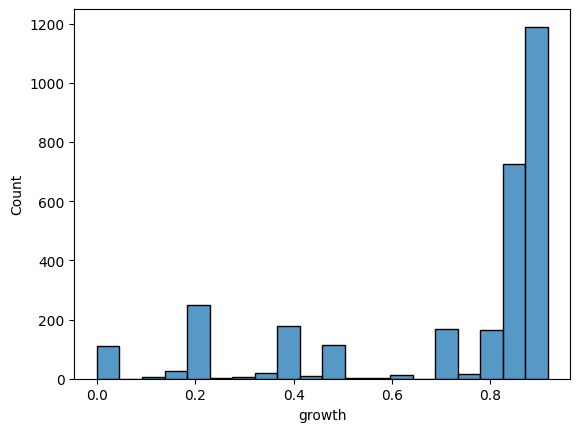

In [23]:
sns.histplot(data=df, x="growth", bins=20)
plt.show()

## Negative growth

In [24]:
df[df['growth'] < 0]

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,TKT1,TKT2,TPI,id,growth,status,strain,rxn_a,rxn_b,no_deletions
126,0.00,0.00,-2.80,-0.00,-0.00,-2.80,-0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"ACALD,EX_h2o_e",-0.00,optimal,1,ACALD,EX_h2o_e,2
962,0.00,0.00,-2.80,0.00,0.00,-2.80,0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"ALCD2x,H2Ot",-0.00,optimal,1,ALCD2x,H2Ot,2
1317,0.00,0.00,-2.80,-0.00,-0.00,-2.80,0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"CO2t,PPC",-0.00,optimal,1,CO2t,PPC,2
1478,-3.05,0.00,-3.05,-0.00,-0.00,-3.05,0.00,0.00,0.00,-3.05,...,-0.00,-0.00,3.05,"CYTBD,PPC",-0.00,optimal,1,CYTBD,PPC,2
1691,0.00,0.00,-2.80,-0.00,-0.00,-2.80,0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"ETOHt2r,H2Ot",-0.00,optimal,1,ETOHt2r,H2Ot,2
2010,0.00,0.00,-2.80,-0.00,-0.00,-2.80,0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"EX_co2_e,PPC",-0.00,optimal,1,EX_co2_e,PPC,2
2035,0.00,0.00,-2.80,-0.00,-0.00,-2.80,0.00,0.00,0.00,0.00,...,0.00,0.00,1.40,"EX_etoh_e,EX_h2o_e",-0.00,optimal,1,EX_etoh_e,EX_h2o_e,2
2132,-6.71,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-6.71,...,0.00,0.00,3.36,"EX_for_e,H2Ot",-0.00,optimal,1,EX_for_e,H2Ot,2
2145,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,1.86,"EX_for_e,PDH",-0.00,optimal,1,EX_for_e,PDH,2
2616,-6.71,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-6.71,...,0.00,0.00,3.36,"EX_h2o_e,PFL",-0.00,optimal,1,EX_h2o_e,PFL,2


11 rows of __negative__ growth

Replace negative growth with 0

In [25]:
for row in range(len(df)):
    if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0

/tmp/ipykernel_10218/766195947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0


## Create _dummy variables_ for `status`

In [26]:
dummy_status = pd.get_dummies(df['status'])
df = pd.concat([df, dummy_status], axis=1)
df

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,TPI,id,growth,status,strain,rxn_a,rxn_b,no_deletions,infeasible,optimal
0,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,7.48,ACALD,0.87,optimal,1,ACALD,None,1,0,1
1,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,7.48,ACALDt,0.87,optimal,1,ACALDt,None,1,0,1
2,0.00,0.00,0.00,6.01,6.01,0.00,0.00,5.06,0.00,0.00,...,7.48,ACKr,0.87,optimal,1,ACKr,None,1,0,1
5,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,7.48,ACt2r,0.87,optimal,1,ACt2r,None,1,0,1
6,0.00,0.00,-0.00,6.01,6.01,-0.00,0.00,5.06,0.00,0.00,...,7.48,ADK1,0.87,optimal,1,ADK1,None,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647,0.00,0.00,0.00,7.61,7.61,0.00,1.88,6.70,0.00,0.00,...,8.70,"THD2,TKT2",0.85,optimal,1,THD2,TKT2,2,0,1
4648,0.00,0.00,0.00,0.76,0.76,0.00,10.97,0.00,0.00,0.00,...,0.00,"THD2,TPI",0.70,optimal,1,THD2,TPI,2,0,1
4650,0.00,0.00,0.00,0.96,0.96,0.00,0.00,0.96,0.00,0.00,...,0.48,"TKT1,TKT2",0.00,optimal,1,TKT1,TKT2,2,0,1
4651,0.00,0.00,0.00,0.96,0.96,0.00,0.00,0.96,0.00,0.00,...,0.48,"TKT1,TPI",0.00,infeasible,1,TKT1,TPI,2,1,0


### Check Linear Correlations

##### Point Biserial Correlation

In [27]:
pearsons = df.drop(columns=critical_rxn).corr(numeric_only=True)['optimal'].sort_values(ascending=False)
spearman = df.drop(columns=critical_rxn).corr(numeric_only=True, method='spearman')['optimal'].sort_values(ascending=False)

corr_matrix = pd.DataFrame({'pearsons':pearsons, 'spearman':spearman})
corr_matrix.sort_values(by='pearsons')

,pearsons,spearman
infeasible,-1.00,-1.00
EX_o2_e,-0.27,-0.20
GLUDy,-0.26,-0.24
CO2t,-0.24,-0.16
H2Ot,-0.24,-0.18
...,...,...
EX_acald_e,NaN,NaN
EX_fru_e,NaN,NaN
EX_mal__L_e,NaN,NaN
FRUpts2,NaN,NaN


In [28]:
corr_matrix[abs(corr_matrix['pearsons']) < 0.1]

,pearsons,spearman
ACALD,0.02,0.03
ACALDt,0.00,0.00
ACKr,-0.04,0.01
ACt2r,-0.04,0.02
ADK1,0.04,0.03
AKGt2r,-0.01,0.01
ALCD2x,0.02,0.03
ATPM,-0.01,-0.01
D_LACt2,-0.01,-0.00
ETOHt2r,0.02,0.05


# AI / ML Ideas

## Create _training_ and _test_ sets and _data normalization_

Create a `df` keeping only _non critical_ reactions.

In [29]:
df.drop(columns=critical_rxn, inplace=True)

In [30]:
df.columns

Index(['ACALD', 'ACALDt', 'ACKr', 'ACt2r', 'ADK1', 'AKGDH', 'AKGt2r', 'ALCD2x',
       'ATPM', 'ATPS4r', 'CO2t', 'CYTBD', 'D_LACt2', 'ETOHt2r', 'EX_ac_e',
       'EX_acald_e', 'EX_akg_e', 'EX_co2_e', 'EX_etoh_e', 'EX_for_e',
       'EX_fru_e', 'EX_fum_e', 'EX_gln__L_e', 'EX_glu__L_e', 'EX_h2o_e',
       'EX_lac__D_e', 'EX_mal__L_e', 'EX_o2_e', 'EX_pyr_e', 'EX_succ_e', 'FBA',
       'FBP', 'FORt2', 'FORti', 'FRD7', 'FRUpts2', 'FUM', 'FUMt2_2', 'G6PDH2r',
       'GLNabc', 'GLUDy', 'GLUN', 'GLUSy', 'GLUt2r', 'GND', 'H2Ot', 'ICL',
       'LDH_D', 'MALS', 'MALt2_2', 'MDH', 'ME1', 'ME2', 'NADH16', 'NADTRHD',
       'O2t', 'PDH', 'PFK', 'PFL', 'PGI', 'PGL', 'PPC', 'PPCK', 'PPS', 'PTAr',
       'PYK', 'PYRt2', 'RPE', 'SUCCt2_2', 'SUCCt3', 'SUCDi', 'SUCOAS', 'TALA',
       'THD2', 'TKT1', 'TKT2', 'TPI', 'id', 'growth', 'status', 'strain',
       'rxn_a', 'rxn_b', 'no_deletions', 'infeasible', 'optimal'],
      dtype='object')

In [31]:
cols_to_drop = ['id', 'rxn_a', 'rxn_b', 'status']
df.drop(columns=cols_to_drop, inplace=True)

df.head()

,ACALD,ACALDt,ACKr,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,ATPM,ATPS4r,...,TALA,THD2,TKT1,TKT2,TPI,growth,strain,no_deletions,infeasible,optimal
0,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,8.39,45.51,...,1.50,0.00,1.50,1.18,7.48,0.87,1,1,0,1
1,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,8.39,45.51,...,1.50,0.00,1.50,1.18,7.48,0.87,1,1,0,1
2,0.00,0.00,0.00,0.00,0.00,5.06,0.00,0.00,8.39,45.51,...,1.50,0.00,1.50,1.18,7.48,0.87,1,1,0,1
5,0.00,0.00,-0.00,-0.00,0.00,5.06,0.00,0.00,8.39,45.51,...,1.50,0.00,1.50,1.18,7.48,0.87,1,1,0,1
6,0.00,0.00,-0.00,-0.00,0.00,5.06,0.00,0.00,8.39,45.51,...,1.50,0.00,1.50,1.18,7.48,0.87,1,1,0,1


In [32]:
df.shape

(3003, 82)

In [34]:
df['val_growth'] = np.nan

growth_strain_1 = e_coli_model.optimize().objective_value
# growth_strain_2 = 6
growth_threshold = 0.1

for row in range(len(df)):
    
    if(df['strain'].iloc[row] == 1):
        if (df['growth'].iloc[row] >  growth_strain_1 - growth_strain_1 * growth_threshold) and (df['growth'].iloc[row] >  growth_strain_1 - growth_strain_1 * growth_threshold):
            df['val_growth'].iloc[row] = 1
        else:
            df['val_growth'].iloc[row] = 0
    elif(df['strain'].iloc[row] == 2):
        if (df['growth'].iloc[row] >  growth_strain_2 - growth_strain_2 * growth_threshold) and (df['growth'].iloc[row] >  growth_strain_2 - growth_strain_2 * growth_threshold):
            df['val_growth'].iloc[row] = 1
        else:
            df['val_growth'].iloc[row] = 0

/tmp/ipykernel_10218/338346607.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_growth'].iloc[row] = 1
/tmp/ipykernel_10218/338346607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_growth'].iloc[row] = 0


In [36]:
df.tail()

,ACALD,ACALDt,ACKr,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,ATPM,ATPS4r,...,THD2,TKT1,TKT2,TPI,growth,strain,no_deletions,infeasible,optimal,val_growth
4647,0.00,0.00,0.00,0.00,1.88,6.70,0.00,0.00,8.39,47.61,...,0.00,0.31,0.00,8.70,0.85,1,2,0,1,1.00
4648,0.00,0.00,0.00,0.00,10.97,0.00,0.00,0.00,8.39,63.79,...,0.00,9.17,8.92,0.00,0.70,1,2,0,1,0.00
4650,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,8.39,6.47,...,0.00,0.00,0.00,0.48,0.00,1,2,0,1,0.00
4651,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,8.39,6.47,...,0.00,0.00,0.00,0.48,0.00,1,2,1,0,0.00
4653,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,8.39,6.47,...,0.00,-0.00,0.00,0.48,0.00,1,2,1,0,0.00


### Basic ML libraries

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define **target** variable

We need to better define the target that we want to predict!

(The most simple and obvious answer is to predit **optimal** column)

Θα *δοκιμάσω* να χρησιμοποιήσω ως στόχο την πρόβλεψη του αν πρόκειται για infeasible

In [38]:
df['target'] = (1-df['val_growth']) * df['infeasible']
# df['target'] = df['infeasible']
df['target'].value_counts()

0.00    2940
1.00      63
Name: target, dtype: int64

In [39]:
df.columns

Index(['ACALD', 'ACALDt', 'ACKr', 'ACt2r', 'ADK1', 'AKGDH', 'AKGt2r', 'ALCD2x',
       'ATPM', 'ATPS4r', 'CO2t', 'CYTBD', 'D_LACt2', 'ETOHt2r', 'EX_ac_e',
       'EX_acald_e', 'EX_akg_e', 'EX_co2_e', 'EX_etoh_e', 'EX_for_e',
       'EX_fru_e', 'EX_fum_e', 'EX_gln__L_e', 'EX_glu__L_e', 'EX_h2o_e',
       'EX_lac__D_e', 'EX_mal__L_e', 'EX_o2_e', 'EX_pyr_e', 'EX_succ_e', 'FBA',
       'FBP', 'FORt2', 'FORti', 'FRD7', 'FRUpts2', 'FUM', 'FUMt2_2', 'G6PDH2r',
       'GLNabc', 'GLUDy', 'GLUN', 'GLUSy', 'GLUt2r', 'GND', 'H2Ot', 'ICL',
       'LDH_D', 'MALS', 'MALt2_2', 'MDH', 'ME1', 'ME2', 'NADH16', 'NADTRHD',
       'O2t', 'PDH', 'PFK', 'PFL', 'PGI', 'PGL', 'PPC', 'PPCK', 'PPS', 'PTAr',
       'PYK', 'PYRt2', 'RPE', 'SUCCt2_2', 'SUCCt3', 'SUCDi', 'SUCOAS', 'TALA',
       'THD2', 'TKT1', 'TKT2', 'TPI', 'growth', 'strain', 'no_deletions',
       'infeasible', 'optimal', 'val_growth', 'target'],
      dtype='object')

In [40]:
X = df.drop(['optimal', 'infeasible', 'growth', 'strain', 'no_deletions', 'target', 'val_growth'], axis=1)
y = df['target']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

(3003, 77)
(3003,)


In [41]:
X_train.columns

Index(['ACALD', 'ACALDt', 'ACKr', 'ACt2r', 'ADK1', 'AKGDH', 'AKGt2r', 'ALCD2x',
       'ATPM', 'ATPS4r', 'CO2t', 'CYTBD', 'D_LACt2', 'ETOHt2r', 'EX_ac_e',
       'EX_acald_e', 'EX_akg_e', 'EX_co2_e', 'EX_etoh_e', 'EX_for_e',
       'EX_fru_e', 'EX_fum_e', 'EX_gln__L_e', 'EX_glu__L_e', 'EX_h2o_e',
       'EX_lac__D_e', 'EX_mal__L_e', 'EX_o2_e', 'EX_pyr_e', 'EX_succ_e', 'FBA',
       'FBP', 'FORt2', 'FORti', 'FRD7', 'FRUpts2', 'FUM', 'FUMt2_2', 'G6PDH2r',
       'GLNabc', 'GLUDy', 'GLUN', 'GLUSy', 'GLUt2r', 'GND', 'H2Ot', 'ICL',
       'LDH_D', 'MALS', 'MALt2_2', 'MDH', 'ME1', 'ME2', 'NADH16', 'NADTRHD',
       'O2t', 'PDH', 'PFK', 'PFL', 'PGI', 'PGL', 'PPC', 'PPCK', 'PPS', 'PTAr',
       'PYK', 'PYRt2', 'RPE', 'SUCCt2_2', 'SUCCt3', 'SUCDi', 'SUCOAS', 'TALA',
       'THD2', 'TKT1', 'TKT2', 'TPI'],
      dtype='object')

Use of stratify sampling to get the same optimal/infeasible rates on train and test sets as to the original dataset.

In [42]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
X_train_scaled = X_train
X_test_scaled = X_test

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10000).fit(X_train_scaled, y_train)

validation_classification(lr_model, X_test_scaled, y_test)

ROC-AUC = 0.9606881214024071
ACCURACY = 0.9966722129783694
F1 = 0.9230769230769231


### SVM Classifier

In [46]:
svc_model, svc_scores = train_svm(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [47]:
validation_classification(svc_model, X_test_scaled, y_test)

ROC-AUC = 0.9606881214024071
ACCURACY = 0.9966722129783694
F1 = 0.9230769230769231


### XGBoost Classifier

In [48]:
xgb_model, xgb_scores = xgb_classifier(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3; 1/20] START C=0.1, gamma=2, kernel=rbf.................................
[CV 2/3; 1/20] END ..C=0.1, gamma=2, kernel=rbf;, score=0.887 total time=   0.1s
[CV 2/3; 4/20] START C=0.05, gamma=2, kernel=linear.............................
[CV 2/3; 4/20] END C=0.05, gamma=2, kernel=linear;, score=0.997 total time=   0.0s
[CV 2/3; 6/20] START C=10, gamma=5, kernel=linear...............................
[CV 2/3; 6/20] END C=10, gamma=5, kernel=linear;, score=0.998 total time=   0.0s
[CV 3/3; 7/20] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 3/3; 7/20] END C=0.01, gamma=0.1, kernel=rbf;, score=0.995 total time=   0.1s
[CV 1/3; 11/20] START C=1, gamma=0.5, kernel=rbf................................
[CV 1/3; 11/20] END .C=1, gamma=0.5, kernel=rbf;, score=0.952 total time=   0.1s
[CV 3/3; 14/20] START C=0.05, gamma=0.01, kernel=rbf.............

[CV 1/3; 1/20] START C=0.1, gamma=2, kernel=rbf.................................
[CV 1/3; 1/20] END ..C=0.1, gamma=2, kernel=rbf;, score=0.920 total time=   0.1s
[CV 1/3; 5/20] START C=0.05, gamma=0.1, kernel=rbf..............................
[CV 1/3; 5/20] END C=0.05, gamma=0.1, kernel=rbf;, score=0.935 total time=   0.1s
[CV 3/3; 9/20] START C=0.5, gamma=1, kernel=rbf.................................
[CV 3/3; 9/20] END ..C=0.5, gamma=1, kernel=rbf;, score=0.995 total time=   0.1s
[CV 2/3; 13/20] START C=10, gamma=1, kernel=linear..............................
[CV 2/3; 13/20] END C=10, gamma=1, kernel=linear;, score=0.998 total time=   0.0s
[CV 2/3; 14/20] START C=0.05, gamma=0.01, kernel=rbf............................
[CV 2/3; 14/20] END C=0.05, gamma=0.01, kernel=rbf;, score=0.896 total time=   0.1s
[CV 3/3; 18/20] START C=0.05, gamma=10, kernel=linear...........................
[CV 3/3; 18/20] END C=0.05, gamma=10, kernel=linear;, score=0.992 total time=   0.0s
[CV 3/3; 1/20] STAR

[CV 1/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 1/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=0.996 total time=   0.1s
[CV 3/3; 4/20] START C=0.05, gamma=2, kernel=linear.............................
[CV 3/3; 4/20] END C=0.05, gamma=2, kernel=linear;, score=0.992 total time=   0.0s
[CV 3/3; 6/20] START C=10, gamma=5, kernel=linear...............................
[CV 3/3; 6/20] END C=10, gamma=5, kernel=linear;, score=0.997 total time=   0.0s
[CV 2/3; 8/20] START C=0.05, gamma=5, kernel=linear.............................
[CV 2/3; 8/20] END C=0.05, gamma=5, kernel=linear;, score=0.997 total time=   0.0s
[CV 1/3; 9/20] START C=0.5, gamma=1, kernel=rbf.................................
[CV 1/3; 9/20] END ..C=0.5, gamma=1, kernel=rbf;, score=0.924 total time=   0.1s
[CV 3/3; 12/20] START C=100, gamma=1, kernel=rbf................................
[CV 3/3; 12/20] END .C=100, gamma=1, kernel=rbf;, score=0.995 total time=   0.1s
[CV 2/3; 16/20] START C

[CV 3/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 3/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=0.994 total time=   0.1s
[CV 2/3; 7/20] START C=0.01, gamma=0.1, kernel=rbf..............................
[CV 2/3; 7/20] END C=0.01, gamma=0.1, kernel=rbf;, score=0.938 total time=   0.1s
[CV 2/3; 11/20] START C=1, gamma=0.5, kernel=rbf................................
[CV 2/3; 11/20] END .C=1, gamma=0.5, kernel=rbf;, score=0.888 total time=   0.1s
[CV 1/3; 15/20] START C=0.01, gamma=0.01, kernel=rbf............................
[CV 1/3; 15/20] END C=0.01, gamma=0.01, kernel=rbf;, score=0.996 total time=   0.1s
[CV 3/3; 19/20] START C=100, gamma=0.1, kernel=linear...........................
[CV 3/3; 19/20] END C=100, gamma=0.1, kernel=linear;, score=0.997 total time=   0.0s
[CV 2/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 2/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=0.966 total time=   0.0s
[CV 3/3; 4/20] STA

In [49]:
validation_classification(xgb_model, X_test_scaled, y_test)

ROC-AUC = 0.9606881214024071
ACCURACY = 0.9966722129783694
F1 = 0.9230769230769231


# Feature Importance to detect reactions for knock-out

In [52]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_test_scaled, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)

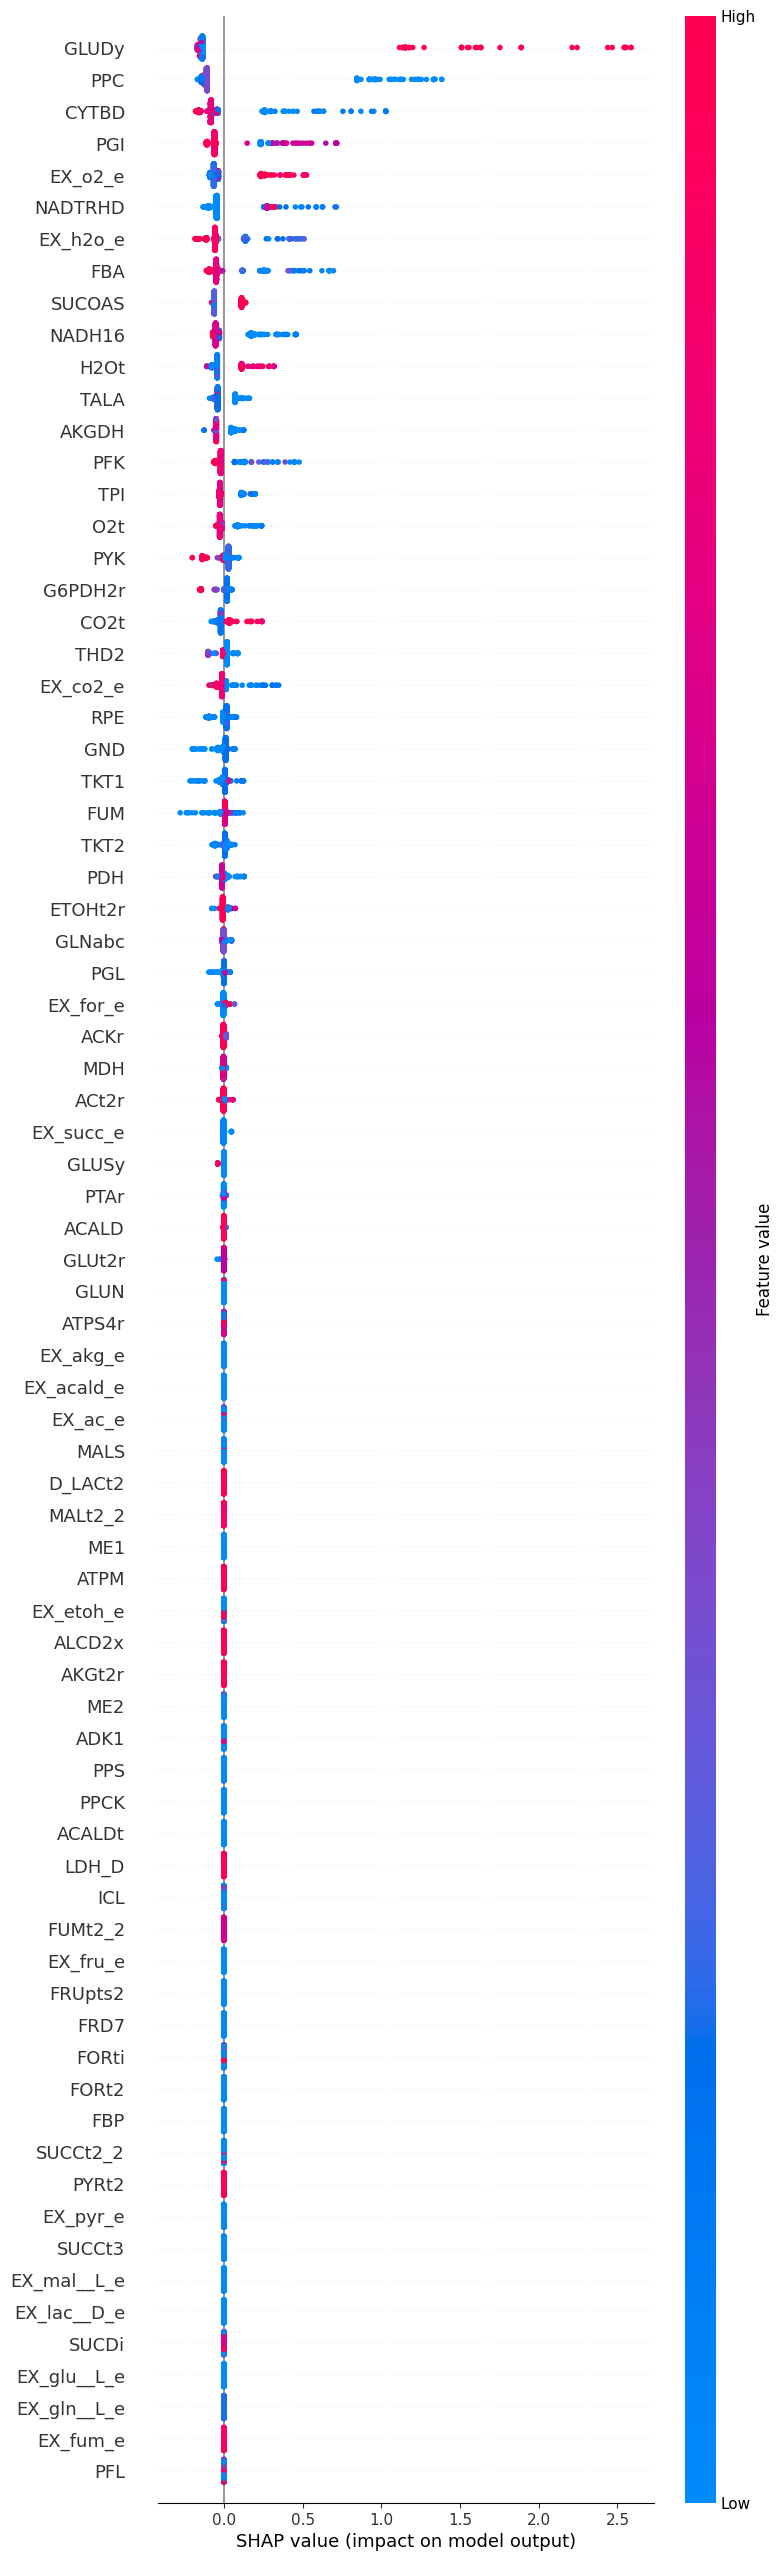

In [54]:
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

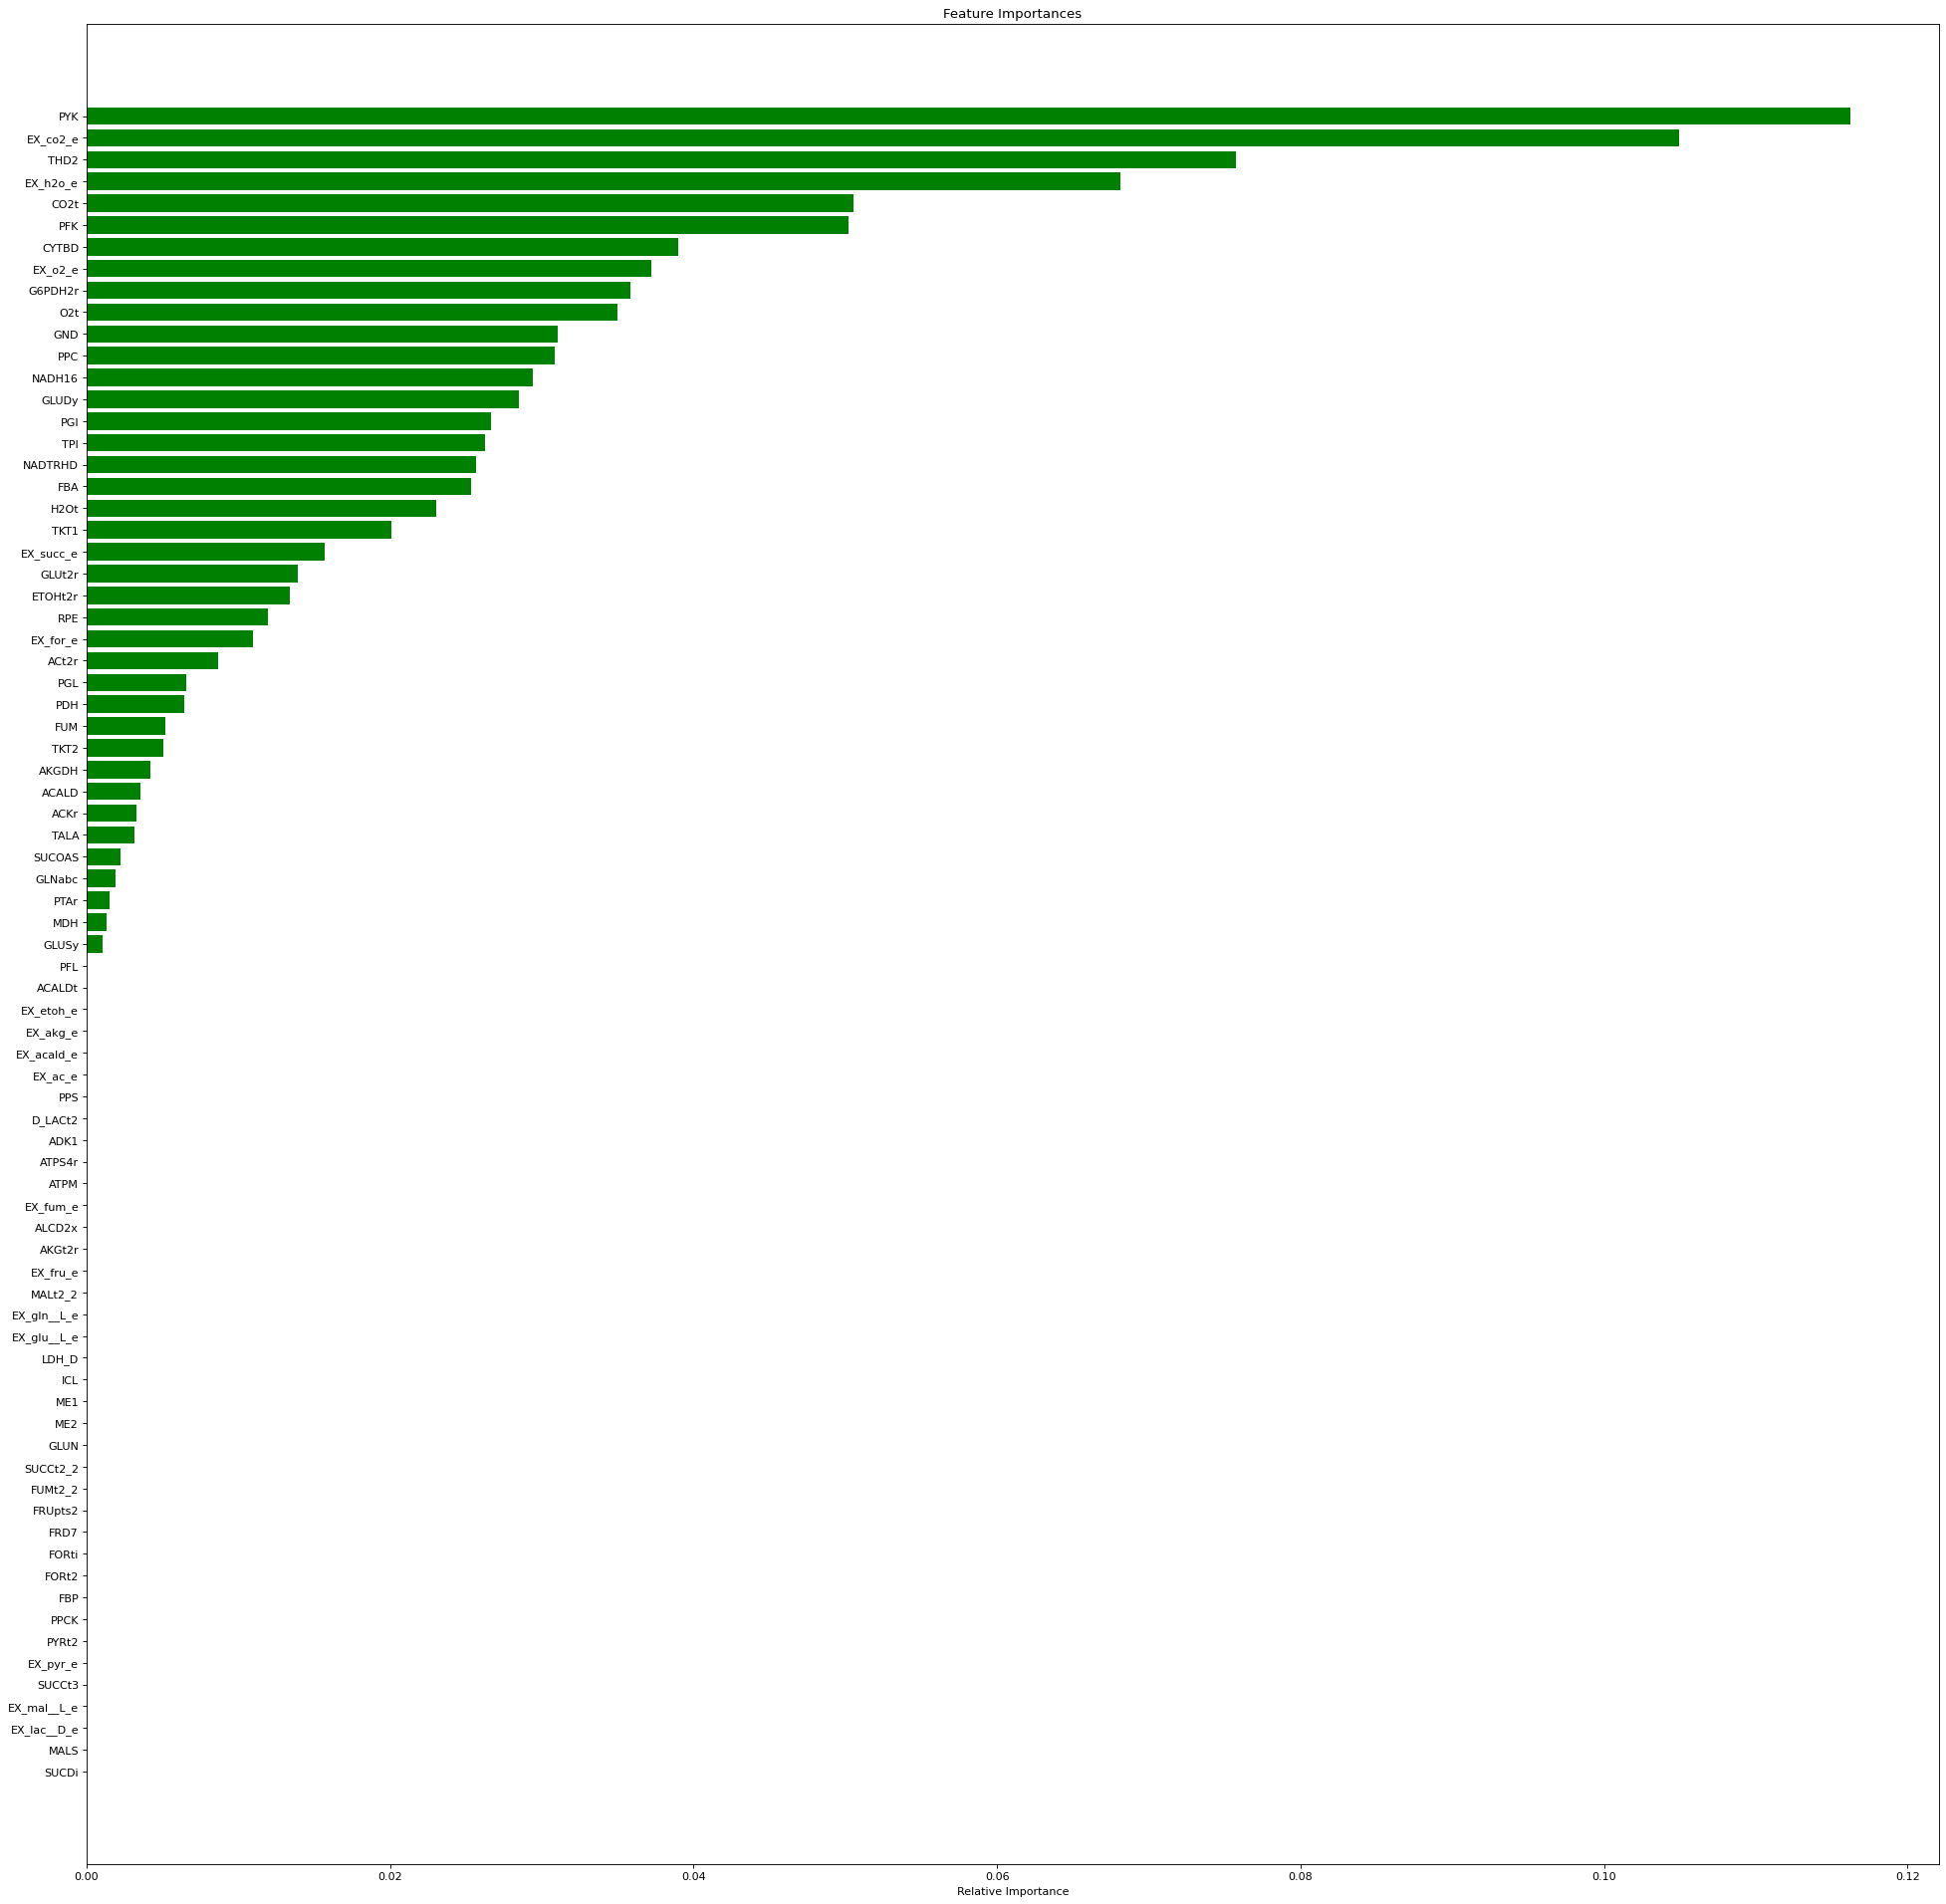

In [60]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

from matplotlib.pyplot import figure

figure(figsize=(30, 30), dpi=80)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Artificial Neural Networks

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2022-11-15 13:11:03.200528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 13:11:03.341325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 13:11:03.341345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 13:11:03.364726: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 13:11:04.426807: W tensorflow/stream_executor/platform/de

In [63]:
n_inputs = len(X_train.columns)

In [64]:
model = Sequential()
model.add(Dense(8, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=5)

2022-11-15 13:11:07.971255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 13:11:07.971285: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 13:11:07.971307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (comex-dell): /proc/driver/nvidia/version does not exist
2022-11-15 13:11:07.971574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
481/481 [==============================] - 1s 898us/step - loss: 0.3954 - accuracy: 0.8085 - precision: 0.0142 - recall: 0.1200
Epoch 2/25
481/481 [==============================] - 1s 1ms/step - loss: 0.0350 - accuracy: 0.9813 - precision: 0.8571 - recall: 0.1200
Epoch 3/25
481/481 [==============================] - 0s 988us/step - loss: 0.0300 - accuracy: 0.9825 - precision: 1.0000 - recall: 0.1600
Epoch 4/25
481/481 [==============================] - 0s 892us/step - loss: 0.0257 - accuracy: 0.9825 - precision: 1.0000 - recall: 0.1600
Epoch 5/25
481/481 [==============================] - 1s 1ms/step - loss: 0.0231 - accuracy: 0.9825 - precision: 1.0000 - recall: 0.1600
Epoch 6/25
481/481 [==============================] - 0s 1ms/step - loss: 0.0222 - accuracy: 0.9825 - precision: 1.0000 - recall: 0.1600
Epoch 7/25
481/481 [==============================] - 1s 1ms/step - loss: 0.0213 - accuracy: 0.9825 - precision: 1.0000 - recall: 0.1600
Epoch 8/25
481/481 [===============

In [65]:
score = model.evaluate(X_test_scaled, y_test,verbose=1)

19/19 [==============================] - 0s 815us/step - loss: 0.0119 - accuracy: 0.9933 - precision: 0.8000 - recall: 0.9231


In [66]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)

print('ROC-AUC =', roc_auc_score(y_test, y_pred))
print('ACCURACY =', accuracy_score(y_test, y_pred))
print('F1 =', f1_score(y_test, y_pred))

19/19 [==============================] - 0s 765us/step
ROC-AUC = 0.9589874411302983
ACCURACY = 0.9933444259567388
F1 = 0.8571428571428571


In [84]:
e = shap.KernelExplainer(model, X_train_scaled.iloc[:10,:])

In [85]:
shap_values = e.shap_values(X_test_scaled, nsamples=500)

  0%|          | 0/601 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


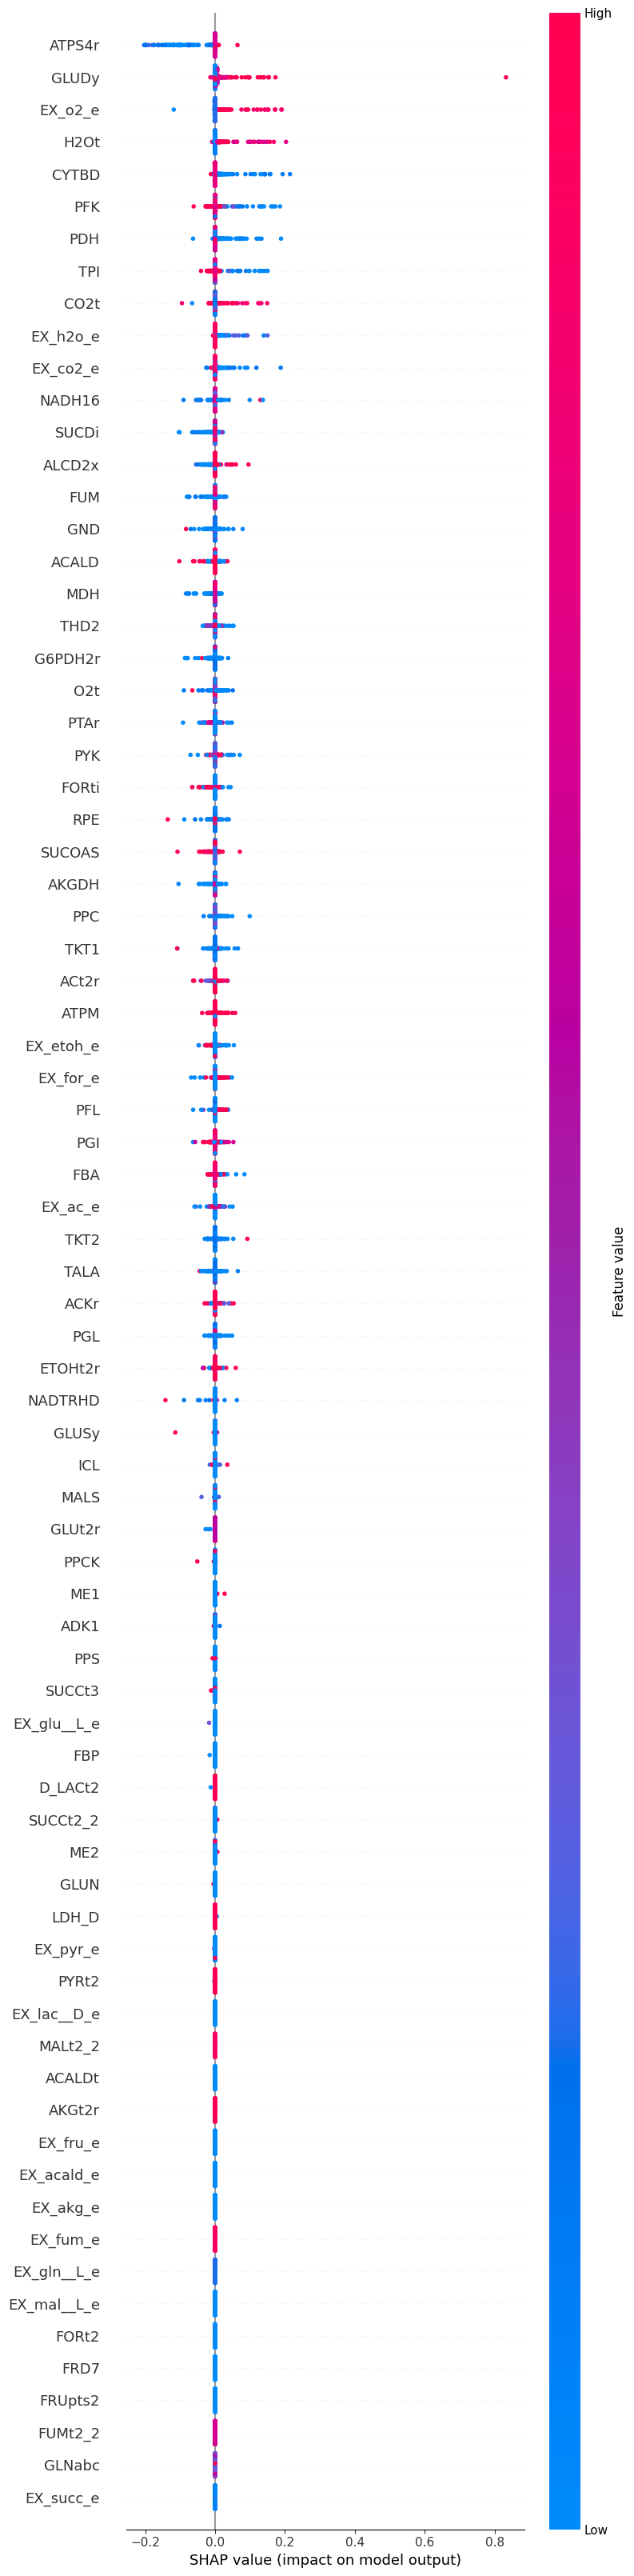

In [87]:
shap.summary_plot(shap_values[0], X_test_scaled, feature_names=X_test.columns, max_display=X_test.shape[1])

# ELI5 

In [90]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from sklearn.svm import SVC

perm = PermutationImportance(xgb_model).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist(), top=X_test.shape[1])

Weight,Feature
0.0073 ± 0.0016,GLUDy
0.0050 ± 0.0021,PPC
0.0023 ± 0.0027,CYTBD
0.0013 ± 0.0013,PFK
0.0010 ± 0.0016,O2t
0.0010 ± 0.0016,EX_co2_e
0.0007 ± 0.0016,EX_o2_e
0.0007 ± 0.0016,EX_for_e
0.0007 ± 0.0016,THD2
0.0003 ± 0.0013,NADTRHD


# Feature Selection

## RFECV

In [91]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

estimator = xgb_model

selector = RFECV(estimator)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,ACALD,1
1,True,ACALDt,1
2,True,ACKr,1
3,True,ACt2r,1
4,True,ADK1,1
...,...,...,...
72,True,TALA,1
73,True,THD2,1
74,True,TKT1,1
75,True,TKT2,1


In [92]:
selected_features[selected_features['selected'] == False].sort_values(by='rank')

,selected,features_names,rank
70,False,SUCDi,2


## Boruta

In [93]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [94]:
from boruta import BorutaPy

# model = xgb.XGBClassifier()
model = xgb_model

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

feat_selector.fit(np.array(X_train_scaled), np.array(y_train))

BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bynode=1, colsample_bytree=0.3,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=0.2, gpu_id=-1,
                                 grow_policy='depthwise', importance_type=None,
                                 interaction_constraints='', learning_rate=0.1,
                                 max_bin=256, max_cat_threshold=64,
                                 max_cat_to_onehot=4, max_delta_step=0,
                                 max_depth=8, max_leaves=0, min_child_weight=3,
                                 missing=nan, monotone_constraints='()',
                                 n_estimators=108, n_jobs=0,
                                 num_parallel_tree=1, predictor='auto',
                                 random_state=2045058245, ...),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FF344741440)

In [95]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  ACALD  - Ranking:  4
Doesn't pass the test:  ACALDt  - Ranking:  43
Doesn't pass the test:  ACKr  - Ranking:  14
Doesn't pass the test:  ACt2r  - Ranking:  6
Doesn't pass the test:  ADK1  - Ranking:  43
Doesn't pass the test:  AKGDH  - Ranking:  14
Doesn't pass the test:  AKGt2r  - Ranking:  43
Doesn't pass the test:  ALCD2x  - Ranking:  17
Doesn't pass the test:  ATPM  - Ranking:  43
Doesn't pass the test:  ATPS4r  - Ranking:  2
Passes the test:  CO2t  - Ranking:  1
Passes the test:  CYTBD  - Ranking:  1
Doesn't pass the test:  D_LACt2  - Ranking:  43
Doesn't pass the test:  ETOHt2r  - Ranking:  15
Doesn't pass the test:  EX_ac_e  - Ranking:  24
Doesn't pass the test:  EX_acald_e  - Ranking:  43
Doesn't pass the test:  EX_akg_e  - Ranking:  43
Passes the test:  EX_co2_e  - Ranking:  1
Doesn't pass the test:  EX_etoh_e  - Ranking:  20
Doesn't pass the test:  EX_for_e  - Ranking:  24
Doesn't pass the test:  EX_fru

In [96]:
selected_features = pd.DataFrame()
selected_features['selected'] = feat_selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = feat_selector.ranking_
selected_features.sort_values(by='selected')

,selected,features_names,rank
0,False,ACALD,4
51,False,ME1,43
50,False,MDH,9
49,False,MALt2_2,43
48,False,MALS,43
...,...,...,...
59,True,PGI,1
55,True,O2t,1
17,True,EX_co2_e,1
27,True,EX_o2_e,1


In [99]:
selected_features[selected_features['selected'] == False].sort_values(by='rank', ascending=False)

,selected,features_names,rank
31,False,FBP,43
37,False,FUMt2_2,43
35,False,FRUpts2,43
68,False,SUCCt2_2,43
41,False,GLUN,43
...,...,...,...
44,False,GND,2
42,False,GLUSy,2
30,False,FBA,2
9,False,ATPS4r,2


# Validate Deletions

In [100]:
from cobra.io import load_model
from cobra.io.json import load_json_model

from main import *

cobra_model = load_model("textbook")

array(['FBP', 'FUMt2_2', 'FRUpts2', 'SUCCt2_2', 'GLUN', 'FORt2', 'PPCK',
       'EX_succ_e', 'EX_pyr_e', 'EX_mal__L_e', 'EX_lac__D_e',
       'EX_glu__L_e', 'EX_gln__L_e', 'EX_fum_e', 'EX_fru_e'], dtype=object)

In [111]:
# ann = ['FBP']

ann = selected_features[selected_features['selected'] == False].sort_values(by='rank', ascending=False).head(20)['features_names'].values

with cobra_model:
    for rxn in ann:
        cobra_model.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model.optimize()    
    print(solution.objective_value)
    print(solution.status)

0.8739215069684321
optimal
